# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [4]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [5]:
# folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"
adata = sc.read(folder_path + "preprocessed_adata.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [7]:
adata.obs.groupby(['sample']).count().n_genes
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_30288\3723676480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count().n_genes


sample
SF10099       458
SF10432       806
SF10857      2122
SF11082      3350
SF11344      4660
             ... 
SF12594      3264
SF12774      2899
SF9791       1296
SF6118v2      396
SF12704v2    3383
Name: n_genes, Length: 70, dtype: int64

# batch 확인

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# running time: 2m 8s (sc)
# running time: ~5m for 94 samples


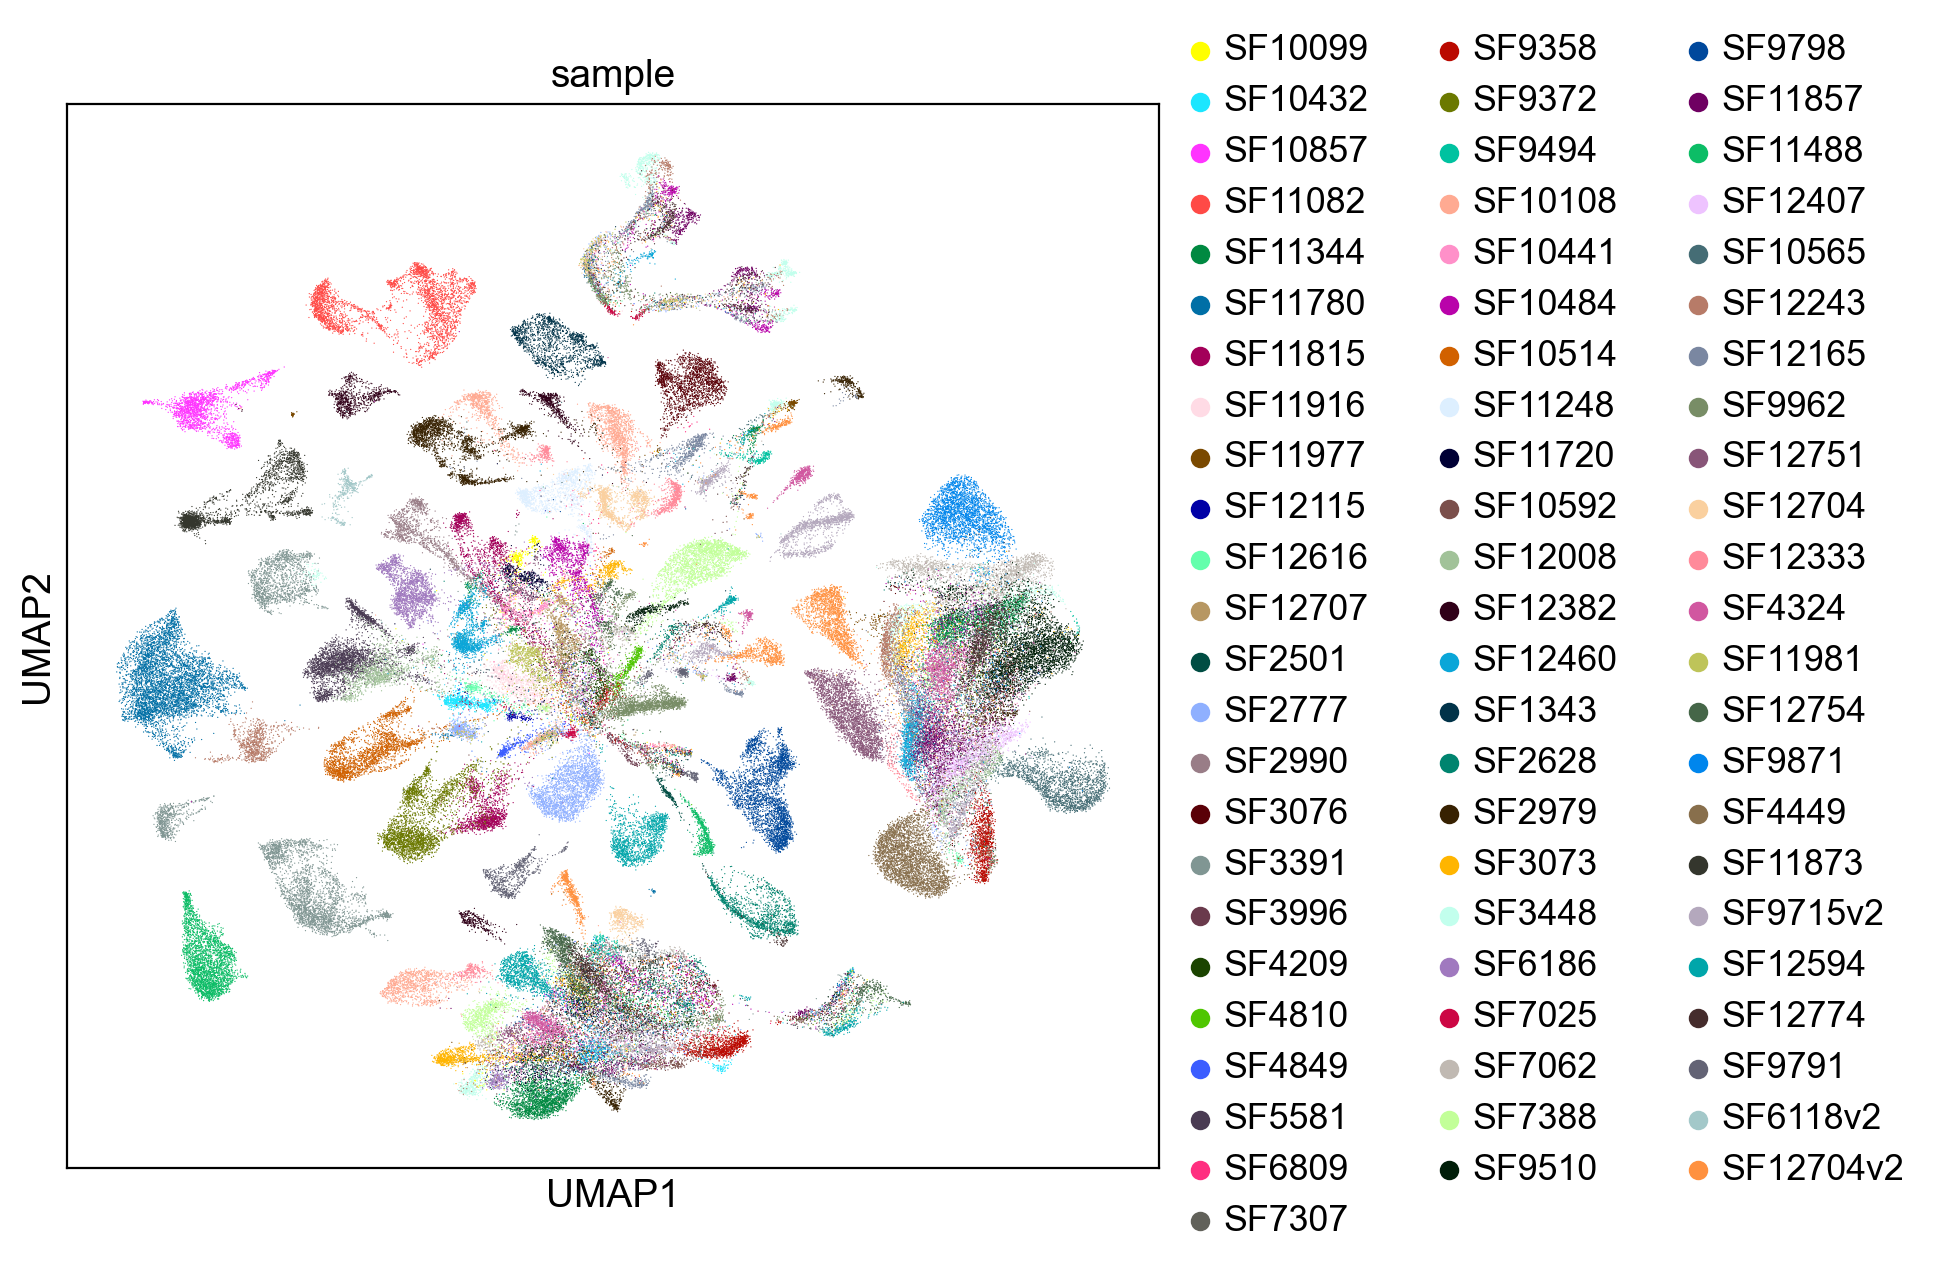

In [9]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))
sc.pl.umap(
    adata,
    color = 'sample',
    # groups = ['SF10432', 'SF9372']
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'sample')

In [10]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수

scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)

c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [11]:
# model.train(max_epochs = 200)
model.train(max_epochs = 100)   # 28m

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [26:22<00:00, 15.79s/it, v_num=1, train_loss_step=6.06e+3, train_loss_epoch=5.47e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [26:22<00:00, 15.83s/it, v_num=1, train_loss_step=6.06e+3, train_loss_epoch=5.47e+3]


In [12]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape
# 7.3GB (크게 차이 없음)

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression() # <- 용량 큼 (~30GB)

# running time: 5m 25s for 94 samples

In [13]:
# data type 확인
# adata.layers['counts']
adata.layers['scvi_normalized']

array([[8.1356227e-08, 4.4312733e-06, 2.2628422e-08, ..., 1.1994473e-05,
        4.9716397e-07, 1.3040020e-05],
       [5.9477060e-08, 4.9231908e-06, 1.9096465e-08, ..., 9.6579624e-06,
        2.1205207e-07, 1.5043660e-05],
       [4.8006527e-08, 2.1829360e-06, 2.8255215e-08, ..., 7.2192179e-06,
        2.7653184e-07, 3.6859645e-05],
       ...,
       [6.4199149e-08, 2.4543426e-06, 1.8430395e-08, ..., 4.8548941e-06,
        1.0070676e-07, 1.6234781e-05],
       [3.6559157e-08, 3.6698225e-06, 2.1085837e-08, ..., 6.2922354e-06,
        2.8491357e-07, 1.7528544e-05],
       [3.0262228e-08, 2.4923640e-06, 2.3078851e-08, ..., 2.8779748e-06,
        1.5029080e-07, 1.0748869e-05]], dtype=float32)

# Batch regression 확인

In [14]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s
# running time: 2m 23s for 94 samples

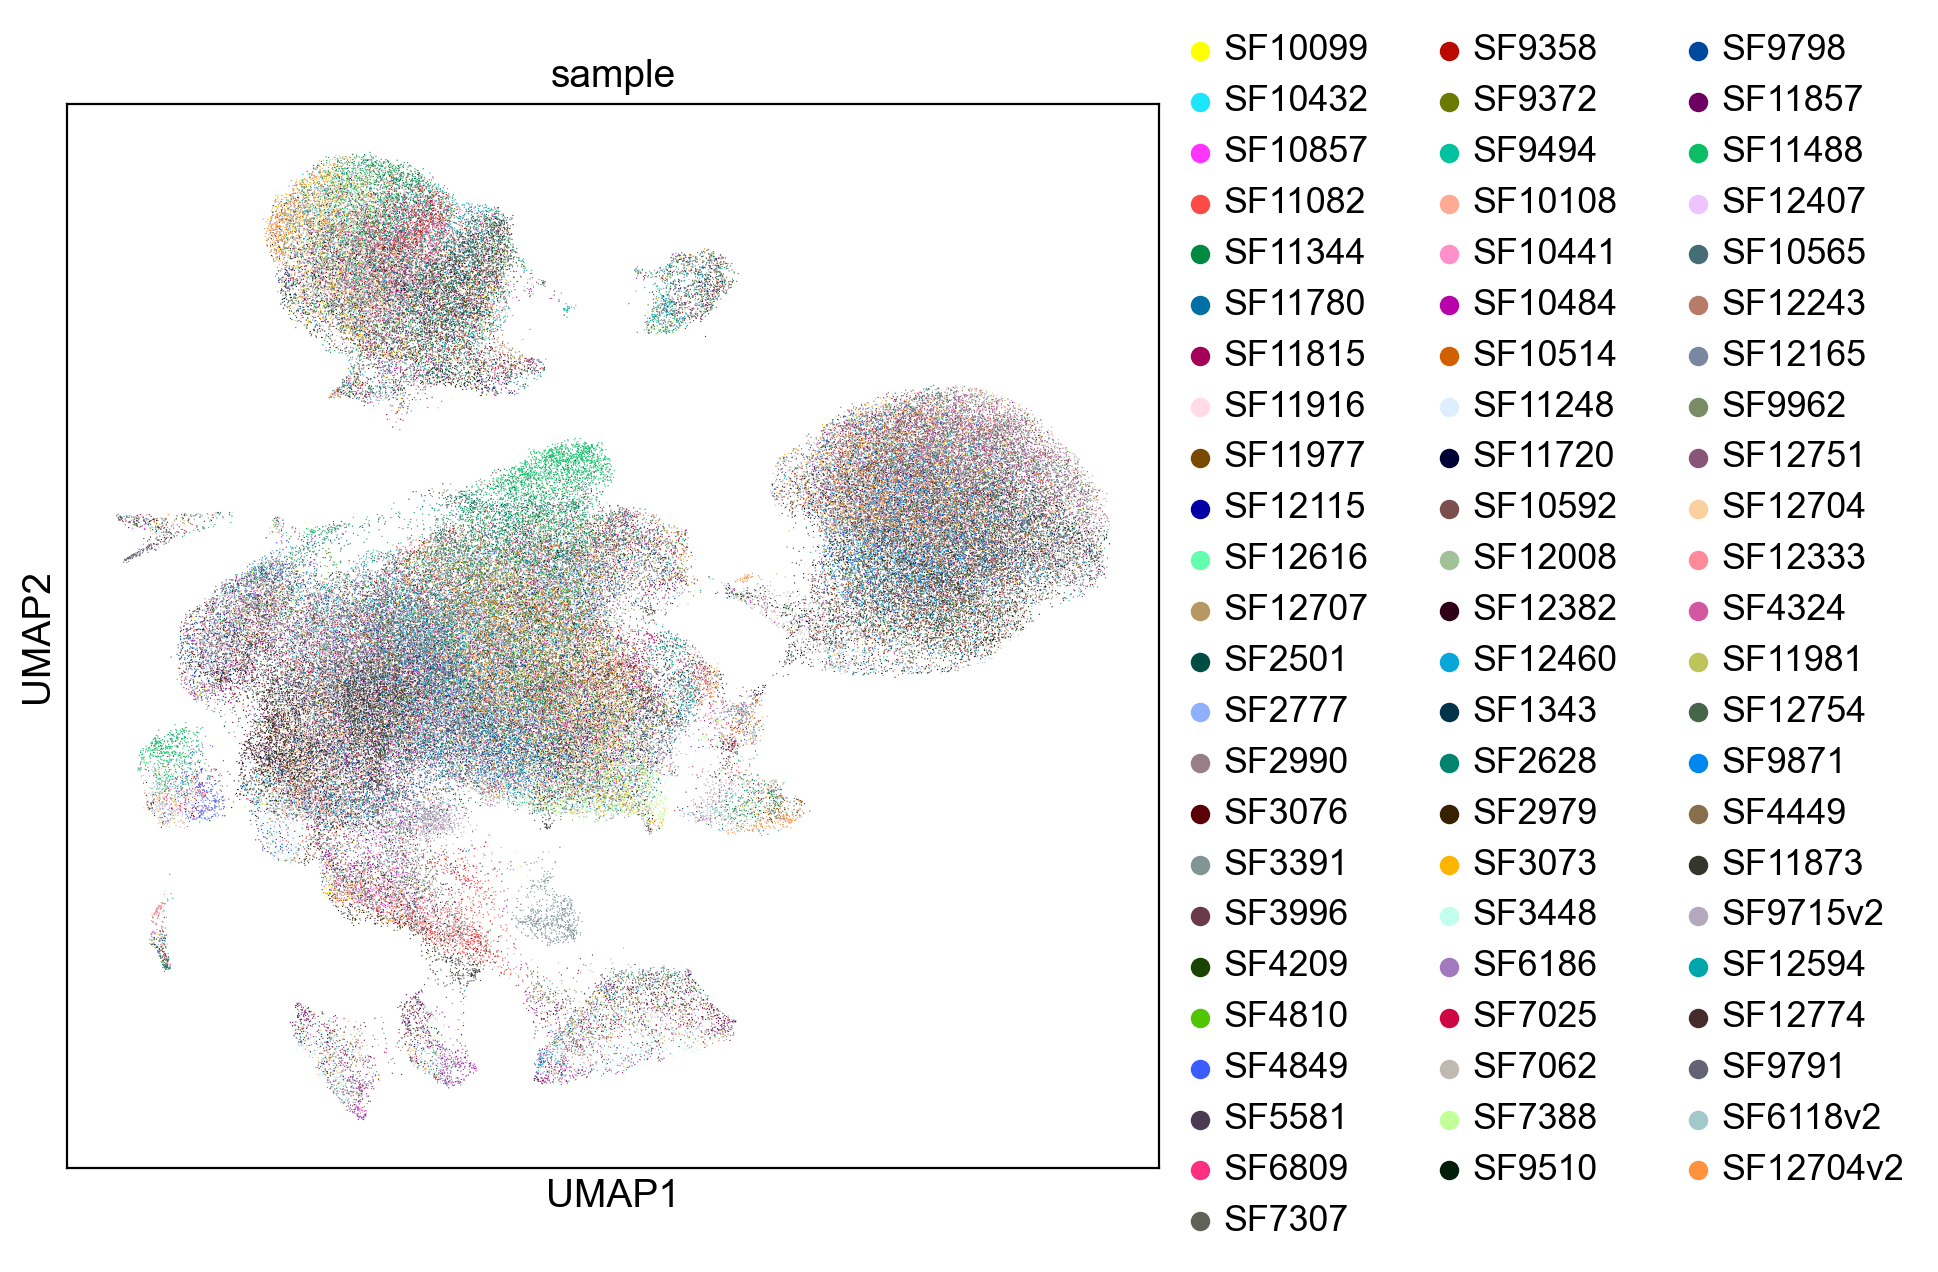

In [15]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))

sc.pl.umap(
    adata,
    color = ['sample'],
)

In [19]:
# Clustering
sc.tl.leiden(adata, resolution=0.5)

# run time: 1m 46s for 94 samples scVI

In [20]:
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_continuous_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

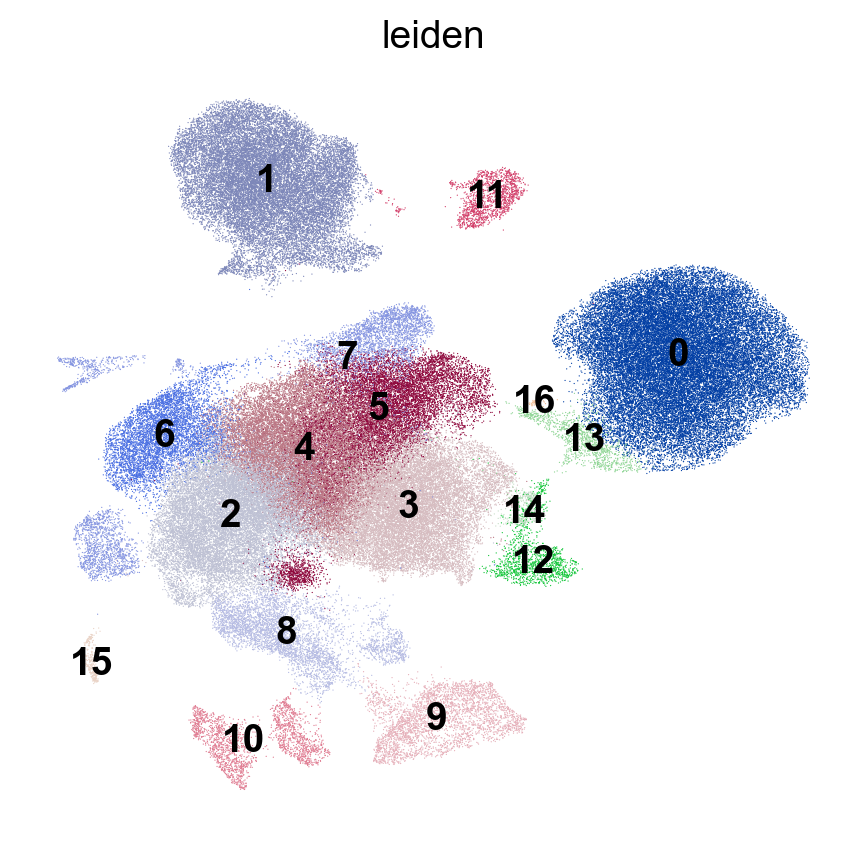

In [21]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    color = ['leiden'],
    frameon = False,
    legend_loc = 'on data'
)

# Save the integrated data and scVI model

In [22]:
# scvi_normalized layer를 sparse matrix로 저장하기 위한 발악
import numpy as np
count_non_zeros = np.count_nonzero(adata.layers['scvi_normalized'])
count_zeros = adata.layers['scvi_normalized'].size - count_non_zeros
print(count_non_zeros)
print(count_zeros)


4454472692
0


In [23]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장
# running time: 3m 42s for 94 samples
# .h5ad file: 21GB